# Example 1: Weighted Channel Merging with pyCyto

In [1]:
from cyto.utils.utils import *
import dask_image.imread
import matplotlib.pyplot as plt
import numpy as np

## Load image files
pyCyto supports any image loader compatible with numpy/dask. Bioimages may storage in multiple formats and dimension orders. Here we load list of single image files under same directory with Dask Image, utilizing the lazy loading function to facilitate the pipeline optimization. For large dataset dask array is more preferable than numpy for better memory managements.

In [2]:
CH0_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma/ch0/*.tif"
CH1_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/register_denoise_gamma/ch1/*.tif"

In [3]:
# default chunk size: 1 image
image_0 = dask_image.imread.imread(CH0_PATH_PATTERN)
image_1 = dask_image.imread.imread(CH1_PATH_PATTERN)

image_0

dask.array<_map_read_frame, shape=(12949, 2400, 2400), dtype=uint16, chunksize=(1, 2400, 2400), chunktype=numpy.ndarray>

Have a first glance of the images

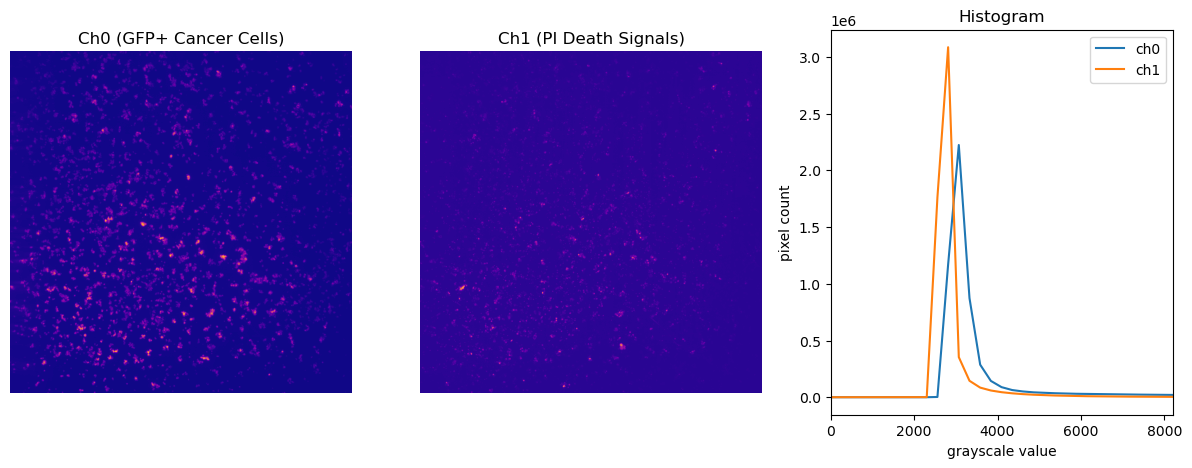

In [23]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

axs[0].imshow(image_0[0,:,:],cmap="plasma")
axs[0].set_axis_off()
axs[0].set_title("Ch0 (GFP+ Cancer Cells)")

axs[1].imshow(image_1[0,:,:],cmap="plasma")
axs[1].set_axis_off()
axs[1].set_title("Ch1 (PI Death Signals)")

# create the histogram
histogram_0, bin_edges_0 = np.histogram(image_0[0,:,:], bins=256, range=(0, 2**16-1))
histogram_1, bin_edges_1 = np.histogram(image_1[0,:,:], bins=256, range=(0, 2**16-1))
axs[2].set_title("Histogram")
axs[2].set_xlabel("grayscale value")
axs[2].set_ylabel("pixel count")
axs[2].set_xlim([0.0, (2**16-1)/8])  # <- named arguments do not work here

axs[2].plot(bin_edges_0[0:-1], histogram_0, label="ch0")
axs[2].plot(bin_edges_1[0:-1], histogram_1, label="ch1")

plt.legend()

User may provide custom weighted value among channels to generate the combined output. To get the custom weighting we may first measure the mean value across first 10 slices in individual channels.

Dask array can be mixed with numpy functions, but you will need to apply `compute()` to get the lazy loading result.

In [5]:
ch0_mean = np.mean(image_0[:10,:,:])
ch1_mean = np.mean(image_1[:10,:,:])

print("channel means: [{:.2f}, {:.2f}]".format(ch0_mean.compute(),ch1_mean.compute()))

channel means: [4426.34, 3063.17]


For linear combined channel weights, the output channel will be combined as 
$$I_{out}=\sum_iwI_i$$

Here we use get the channel weight by
$$w_i=1-\frac{\sum_{i\neq j}\bar{I_i}}{\sum_i\bar{I_i}}$$

In [6]:
weight0 = 1 - ch1_mean/(ch0_mean+ch1_mean)
weight1 = 1 - ch0_mean/(ch0_mean+ch1_mean)
print("channel weights: [{:.2f}, {:.2f}]".format(weight0.compute(),weight1.compute()))

channel weights: [0.59, 0.41]


In [20]:
cm = ChannelMerge(weights=[weight0,weight1])

# data parse to pyCyto classes need to be in dictionary format
input = {"images":[image_0[0,:,:],image_1[1,:,:]]}
res = cm(input)

# combined channel output
weighted = res["output"]
weighted

dask.array<add, shape=(2400, 2400), dtype=uint16, chunksize=(2400, 2400), chunktype=numpy.ndarray>

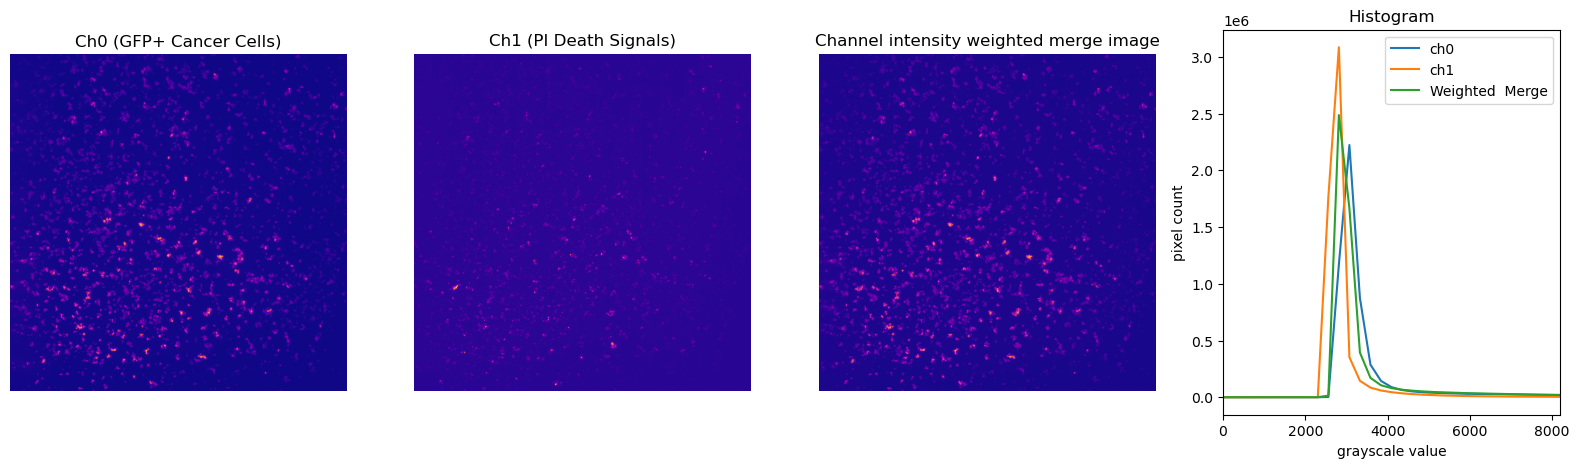

In [22]:
fig, axs = plt.subplots(1,4,figsize=(20,5))

axs[0].imshow(image_0[0,:,:],cmap="plasma")
axs[0].set_axis_off()
axs[0].set_title("Ch0 (GFP+ Cancer Cells)")

axs[1].imshow(image_1[0,:,:],cmap="plasma")
axs[1].set_axis_off()
axs[1].set_title("Ch1 (PI Death Signals)")

axs[2].imshow(weighted,cmap="plasma")
axs[2].set_axis_off()
axs[2].set_title("Channel intensity weighted merge image")

# create the histogram
histogram_weighted, bin_edges_weighted = np.histogram(weighted, bins=256, range=(0, 2**16-1))
axs[3].set_title("Histogram")
axs[3].set_xlabel("grayscale value")
axs[3].set_ylabel("pixel count")
axs[3].set_xlim([0.0, (2**16-1)/8])  # <- named arguments do not work here

axs[3].plot(bin_edges_0[0:-1], histogram_0, label="ch0")
axs[3].plot(bin_edges_1[0:-1], histogram_1, label="ch1")
axs[3].plot(bin_edges_weighted[0:-1], histogram_weighted, label="Weighted  Merge")

plt.legend()